# Overview

At a very high level, Howso Engine is about: 

- Making an accurate prediction (even with limited or sparse data!) 

- Explaining the prediction process 

- Showing key properties of the data 

In this notebook, we will be using the adult data set as an example to demonstrate some of Howso Engine’s capabilities, including cases and features which contribute to predictions, anomalies analysis, and potential improvements to the data to gain more insight into the data.  


In [1]:
import os

import pandas as pd
import plotly.io as pio

from howso import engine
from howso.utilities import infer_feature_attributes
from howso.visuals import (
    plot_anomalies,
    plot_dataset,
    plot_feature_importances,
)

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

In [2]:
# Load adult data
df = pd.read_csv('data/adult.data', header=None)

# Specify column names
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 
              'education-num', 'marital-status', 'occupation',
              'relationship', 'race', 'sex', 'capital-gain', 
              'capital-loss', 'hours-per-week', 'native-country', 'target']

# Sample the data for demo purpose
df = df.sample(1_000).reset_index(drop=True)

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,23,Private,238092,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K
1,54,Self-emp-inc,223752,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,7688,0,40,?,>50K
2,27,Private,177955,5th-6th,3,Never-married,Priv-house-serv,Other-relative,White,Female,2176,0,40,El-Salvador,<=50K
3,31,Private,123430,11th,7,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,65,Mexico,<=50K
4,36,Private,58602,5th-6th,3,Never-married,Other-service,Not-in-family,White,Male,0,0,35,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,20,Private,47541,Some-college,10,Never-married,Sales,Own-child,White,Male,0,0,30,United-States,<=50K
996,28,Private,114158,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Female,0,0,15,United-States,<=50K
997,27,Private,212622,Masters,14,Never-married,Exec-managerial,Own-child,White,Female,0,0,40,United-States,<=50K
998,21,?,143995,Some-college,10,Never-married,?,Own-child,Black,Male,0,0,20,United-States,<=50K


In [3]:
partial_features = {
    "education": {"type": "nominal"}
}

# Infer features types
features = infer_feature_attributes(df, features=partial_features)

# Specify the context and action feature
action_features = ['target']
context_features = features.get_names(without=['target'])

In [4]:
# Create the trainee with custom name
t = engine.Trainee(name='Engine - Predictions and Explanations Recipe', features=features, overwrite_existing=True)

# Train
t.train(df)

# Analyze the model
t.analyze(action_features=action_features)


In [5]:
t.react_into_trainee(residuals=True)

accuracy = t.get_prediction_stats(stats=['accuracy'])['target'].iloc[0]

print("Test set prediction accuracy: {acc}".format(acc=accuracy))

Test set prediction accuracy: 0.717


# Explain

How was the predictions made? 

Howso Engine provides detailed explanation for complete model transparency. Let's examine a subset of the explanations.


## Feature importance (global)

The feature importance information provides insight into the feature[s] which were primary drivers for each of the prediction. This is important to understand in the context of AI bias and discrimination (ex. Sensitive attribute being the primary contribution to a prediction). 

This information is available at the global level (overall model), but can also be extracted at the local level (regional model for each case).

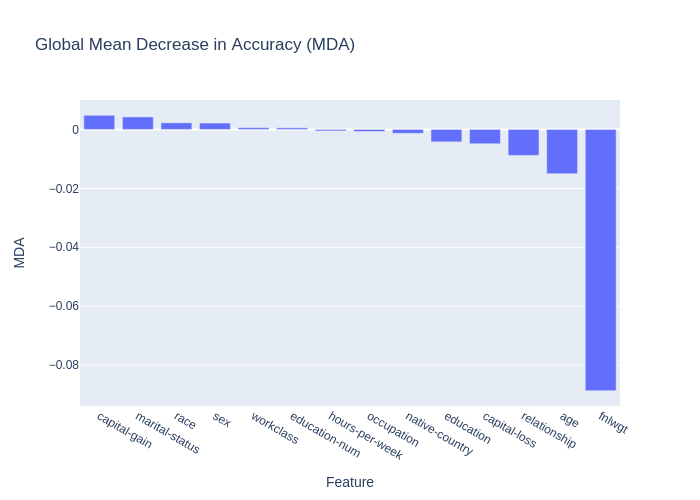

In [6]:
# Extract the global MDA (mean decrease in accuracy)
t.react_into_trainee(action_feature=action_features[0], mda_robust=True, residuals=True)
global_mda = t.get_prediction_stats(action_feature=action_features[0], stats=['mda'])
plot_feature_importances(global_mda, title="Global Mean Decrease in Accuracy (MDA)", yaxis_title="MDA")

## Feature uncertainty (global)

Are there any noisy features? 

Howso Engine’s performance is robust against noisy feature[s], and can maintain a high level of accuracy despite noisy data. 

Part of the reason  Howso Engine can maintain the level of performance despite noisy data is through characterization of feature uncertainties (residuals). The feature residuals can be extracted for user review. Note, the residuals are in the same units as the original features which makes it easy to interpret. For example, the residual for the “age” feature has the unit of years as in the original data.

Feature residuals are available at the global level (overall model) and at the local level (regional model for each case).


In [7]:
# Global feature residuals
global_feature_residuals = t.get_prediction_stats(stats=['mae']).T.rename(columns={'mae':'residuals'}).sort_values('residuals', ascending=False)
global_feature_residuals.iloc[0:10]

,residuals
fnlwgt,77279.361990
capital-gain,1870.018080
age,11.203596
hours-per-week,8.128351
occupation,0.901854
education-num,0.815398
education,0.815398
relationship,0.743104
marital-status,0.668120
workclass,0.465971


# "Show me..."

Howso Engine can be used to show interesting information pertaining to the data and model, such as anomalous cases and potential model improvements. 
 
For each prediction, Howso Engine can also extract the influential cases and boundary cases to provide an exact explanation to the prediction process. More details on what’s available can be found in the notebook “2-interpretability.ipynb”.


## Anomalous cases

Anomalous cases can exist in the data as either an outlier or inlier. Outliers are cases which are very different than other cases. Inliers are cases which are too similar to other cases and do not follow the expected distribution. Inliers can be an indication of a fraudulent case that is “too good to be true”. 



In [8]:
# Store the familiarity conviction, this will be used to identify anomalous cases
t.analyze()
t.react_into_features(familiarity_conviction_addition=True, distance_contribution=True)
stored_convictions = t.get_cases(session=t.active_session, features=df.columns.tolist() + ['familiarity_conviction_addition','.session_training_index', '.session', 'distance_contribution'])

stored_convictions

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,familiarity_conviction_addition,.session_training_index,.session,distance_contribution
0,23,Private,238092,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K,1.661812,0,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.534657e+11
1,54,Self-emp-inc,223752,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,7688,0,40,?,>50K,25.257236,1,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.746794e+11
2,27,Private,177955,5th-6th,3,Never-married,Priv-house-serv,Other-relative,White,Female,2176,0,40,El-Salvador,<=50K,16.813959,2,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.758218e+11
3,31,Private,123430,11th,7,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,65,Mexico,<=50K,46.093336,3,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.719216e+11
4,36,Private,58602,5th-6th,3,Never-married,Other-service,Not-in-family,White,Male,0,0,35,United-States,<=50K,6.499001,4,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.628231e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,20,Private,47541,Some-college,10,Never-married,Sales,Own-child,White,Male,0,0,30,United-States,<=50K,4.442740,995,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.610584e+11
996,28,Private,114158,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Female,0,0,15,United-States,<=50K,7.834209,996,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.632756e+11
997,27,Private,212622,Masters,14,Never-married,Exec-managerial,Own-child,White,Female,0,0,40,United-States,<=50K,1.332491,997,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.514136e+11
998,21,?,143995,Some-college,10,Never-married,?,Own-child,Black,Male,0,0,20,United-States,<=50K,2.270774,998,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.842981e+11


In [9]:
# Threshold to determine which cases will be deemed anomalous
convict_threshold = 0.75

# Extract the anomalous cases
low_convicts = stored_convictions[stored_convictions['familiarity_conviction_addition'] <= convict_threshold ].sort_values('familiarity_conviction_addition', ascending=True)

# Average distance contribution will be used to determine if a case is an outlier or inlier
average_dist_contribution = low_convicts['distance_contribution'].mean()

# A case with distance contribution greater than average will be tagged as outlier, and vise versa for inliers
cat = ['inlier' if d < average_dist_contribution else 'outlier' for d in low_convicts['distance_contribution']]
low_convicts['category'] = cat

## Outliers

Let’s examine a few outlier cases. Outliers are cases which are very different than other cases.

In [10]:
# Extract the outliers cases
outliers = low_convicts[low_convicts['category'] == 'outlier'].reset_index(drop=True)
outliers

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,familiarity_conviction_addition,.session_training_index,.session,distance_contribution,category
0,45,Self-emp-inc,108100,Bachelors,13,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,99999,0,25,?,>50K,0.008858,425,9fe95ce2-8fba-4037-8952-792f6ae3513b,9.410137e+11,outlier
1,78,Self-emp-not-inc,316261,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Male,99999,0,20,United-States,>50K,0.017139,895,9fe95ce2-8fba-4037-8952-792f6ae3513b,8.574791e+11,outlier
2,47,Private,181307,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,99999,0,60,United-States,>50K,0.026391,628,9fe95ce2-8fba-4037-8952-792f6ae3513b,8.136710e+11,outlier
3,42,Private,187795,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,55,United-States,>50K,0.027134,942,9fe95ce2-8fba-4037-8952-792f6ae3513b,8.117767e+11,outlier
4,69,Self-emp-not-inc,240562,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,40,United-States,>50K,0.028827,554,9fe95ce2-8fba-4037-8952-792f6ae3513b,8.069644e+11,outlier
5,36,Private,329980,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Male,27828,0,40,United-States,>50K,0.046396,985,9fe95ce2-8fba-4037-8952-792f6ae3513b,7.806650e+11,outlier
6,73,Private,183213,Assoc-voc,11,Widowed,Prof-specialty,Not-in-family,White,Male,25124,0,60,United-States,>50K,0.050609,126,9fe95ce2-8fba-4037-8952-792f6ae3513b,7.763620e+11,outlier
7,90,Private,87372,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,20051,0,72,United-States,>50K,0.053911,164,9fe95ce2-8fba-4037-8952-792f6ae3513b,7.729186e+11,outlier
8,37,Self-emp-not-inc,32239,HS-grad,9,Divorced,Farming-fishing,Not-in-family,White,Male,27828,0,40,United-States,>50K,0.054383,261,9fe95ce2-8fba-4037-8952-792f6ae3513b,7.715714e+11,outlier
9,40,Federal-gov,56795,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,14084,0,55,United-States,>50K,0.074426,383,9fe95ce2-8fba-4037-8952-792f6ae3513b,7.570757e+11,outlier


In [11]:
# Cache global non-robust residuals into trainee
t.react_into_trainee(residuals=True)

# Get the case_feature_residual_convictions, influential_cases and boundary_cases
details = {'robust_residuals': True,
           'global_case_feature_residual_convictions': True, 
           'local_case_feature_residual_convictions': True}

# Specify outlier cases
outliers_indices = outliers[['.session', '.session_training_index']].values

# React to get the details of each case
results = t.react(case_indices=outliers_indices, 
                  preserve_feature_values=df.columns.tolist(), 
                  leave_case_out=True, 
                  details=details)

In [12]:
# Extract the global and local case feature residual convictions
global_case_feature_residual_convictions = pd.DataFrame(results['details']['global_case_feature_residual_convictions'])[df.columns.tolist()]
local_case_feature_residual_convictions = pd.DataFrame(results['details']['local_case_feature_residual_convictions'])[df.columns.tolist()]

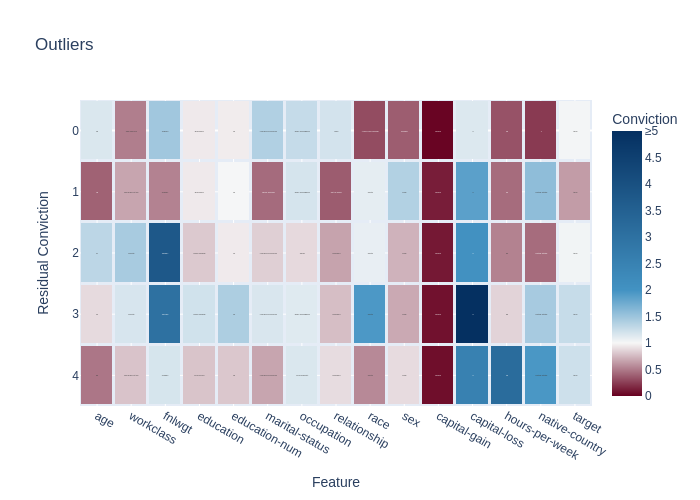

In [13]:
plot_anomalies(outliers, local_case_feature_residual_convictions, title="Outliers", yaxis_title="Residual Conviction")

The heat map explains the reason why each case was an outlier. The darker the shade of red, the higher the contribution to the case being an outlier. 

## Inliers

Let’s examine a few inlier cases. Inliers are cases which are too similar to other cases and do not follow the expected distribution. Inliers can be an indication of a fraudulent case that is “too good to be true”. 

In [14]:
# Get the inlier cases
inliers = low_convicts[low_convicts['category'] == 'inlier'].reset_index(drop=True)
inliers

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,familiarity_conviction_addition,.session_training_index,.session,distance_contribution,category
0,39,Private,548510,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Black,Male,0,0,30,United-States,<=50K,0.219703,131,9fe95ce2-8fba-4037-8952-792f6ae3513b,7.198357e+11,inlier
1,44,Local-gov,177240,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,10520,0,40,United-States,>50K,0.226472,310,9fe95ce2-8fba-4037-8952-792f6ae3513b,7.194035e+11,inlier
2,90,Private,313749,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,25,United-States,<=50K,0.235978,307,9fe95ce2-8fba-4037-8952-792f6ae3513b,7.181623e+11,inlier
3,50,Private,237729,HS-grad,9,Widowed,Sales,Not-in-family,White,Female,0,2444,72,United-States,>50K,0.242381,928,9fe95ce2-8fba-4037-8952-792f6ae3513b,7.173237e+11,inlier
4,60,?,141221,Bachelors,13,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,2163,25,South,<=50K,0.243363,91,9fe95ce2-8fba-4037-8952-792f6ae3513b,7.172839e+11,inlier
5,34,Private,185556,Some-college,10,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,12,United-States,>50K,0.254002,648,9fe95ce2-8fba-4037-8952-792f6ae3513b,7.160157e+11,inlier
6,32,Federal-gov,566117,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,0.254018,787,9fe95ce2-8fba-4037-8952-792f6ae3513b,7.167018e+11,inlier
7,36,Private,659504,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,45,United-States,>50K,0.271227,45,9fe95ce2-8fba-4037-8952-792f6ae3513b,7.151072e+11,inlier
8,22,State-gov,311512,Some-college,10,Married-civ-spouse,Other-service,Husband,Black,Male,0,0,15,United-States,<=50K,0.287414,189,9fe95ce2-8fba-4037-8952-792f6ae3513b,7.134875e+11,inlier
9,22,State-gov,347803,Some-college,10,Never-married,Adm-clerical,Not-in-family,Other,Male,0,0,20,United-States,<=50K,0.289279,950,9fe95ce2-8fba-4037-8952-792f6ae3513b,7.129326e+11,inlier


In [15]:
# Specify the inlier cases
inliers_indices = inliers[['.session', '.session_training_index']].values

# React to get the details of each case
results = t.react(case_indices=inliers_indices, 
                  preserve_feature_values=df.columns.tolist(), 
                  leave_case_out=True, 
                  details=details)

In [16]:
# Extract the global and local case feature residual convictions
global_case_feature_residual_convictions = pd.DataFrame(results['details']['global_case_feature_residual_convictions'])[df.columns.tolist()]
local_case_feature_residual_convictions = pd.DataFrame(results['details']['local_case_feature_residual_convictions'])[df.columns.tolist()]

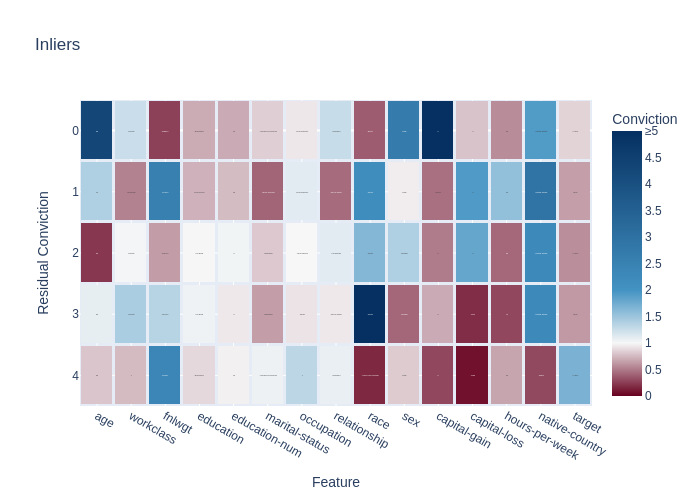

In [17]:
plot_anomalies(inliers, local_case_feature_residual_convictions, title="Inliers", yaxis_title="Residual Conviction")

The heat map explains the reason why each case was an inlier. The darker the shade of blue, the higher the contribution the to case being an inlier.

## Potential improvements

Sparse regions of the model or under defined problems can make it difficult to make an accurate prediction. Howso Engine can be used to identify potential data, or model improvements by examining the residual conviction and density.

In [18]:
# Identify cases for investigation
partial_train_df = stored_convictions
partial_train_cases = partial_train_df[['.session', '.session_training_index']]


In [19]:
# Residual convictions are output via the local_case_feature_residual_convictions explanation
details = {'global_case_feature_residual_convictions':True}

# Get the residual convictions for the specified cases
new_result = t.react(case_indices=partial_train_cases.values.tolist(), 
                     leave_case_out=True, 
                     preserve_feature_values=df.drop(action_features, axis=1).columns.tolist(), 
                     action_features=action_features,
                     details=details)

In [20]:
# Extract residual conviction
target_residual_convictions = [ x['target'] for x in new_result['details']['global_case_feature_residual_convictions'] ]

# Binarize residual conviction
convict_threshold = 0.75
low_residual_conviction = [1 if x <= convict_threshold else 0 for x in target_residual_convictions]

# Density is just the inverse of distance_contribution
density = 1 / partial_train_df['distance_contribution']

# Add new features to the dataframe
partial_train_df['density'] = density
partial_train_df['target_residual_conviction'] = target_residual_convictions
partial_train_df['low_residual_conviction'] = low_residual_conviction

In [21]:
partial_train_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,hours-per-week,native-country,target,familiarity_conviction_addition,.session_training_index,.session,distance_contribution,density,target_residual_conviction,low_residual_conviction
0,23,Private,238092,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,...,40,United-States,<=50K,1.661812,0,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.534657e+11,1.530302e-12,2.067444,0
1,54,Self-emp-inc,223752,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,40,?,>50K,25.257236,1,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.746794e+11,1.482185e-12,0.476537,1
2,27,Private,177955,5th-6th,3,Never-married,Priv-house-serv,Other-relative,White,Female,...,40,El-Salvador,<=50K,16.813959,2,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.758218e+11,1.479680e-12,347.533216,0
3,31,Private,123430,11th,7,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,65,Mexico,<=50K,46.093336,3,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.719216e+11,1.488269e-12,2.358563,0
4,36,Private,58602,5th-6th,3,Never-married,Other-service,Not-in-family,White,Male,...,35,United-States,<=50K,6.499001,4,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.628231e+11,1.508698e-12,1.769014,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,20,Private,47541,Some-college,10,Never-married,Sales,Own-child,White,Male,...,30,United-States,<=50K,4.442740,995,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.610584e+11,1.512726e-12,1.590708,0
996,28,Private,114158,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Female,...,15,United-States,<=50K,7.834209,996,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.632756e+11,1.507669e-12,1.297453,0
997,27,Private,212622,Masters,14,Never-married,Exec-managerial,Own-child,White,Female,...,40,United-States,<=50K,1.332491,997,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.514136e+11,1.535123e-12,11.100766,0
998,21,?,143995,Some-college,10,Never-married,?,Own-child,Black,Male,...,20,United-States,<=50K,2.270774,998,9fe95ce2-8fba-4037-8952-792f6ae3513b,6.842981e+11,1.461351e-12,3.342234,0


In [22]:
# Helper function to resize the data points
def get_sizes(min_size, max_size, series):
    min_value = series.min()
    max_value = series.max()
    
    m = (max_size - min_size) / (max_value - min_value)
    
    sizes = series * m + min_size
    return (sizes)

partial_train_df["density"] = get_sizes(5, 500, partial_train_df["density"])

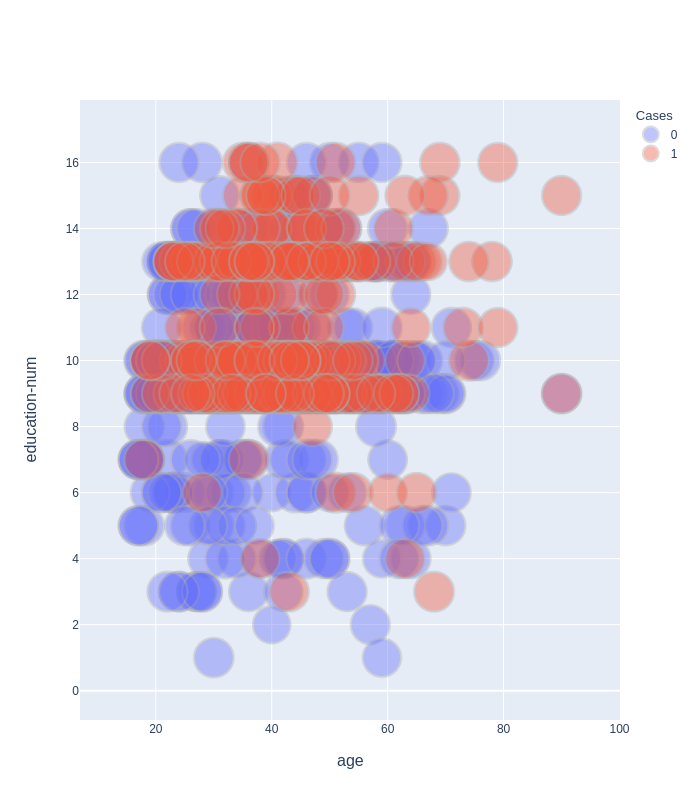

In [23]:
plot_dataset(partial_train_df, x="age", y="education-num", size="density", hue="low_residual_conviction", alpha=0.4)

The above graph is a visualization of the data set in 2-dimensions, with the color as an indication of residual conviction and the size representing the density of the data. More specifically, the orange color represents the low conviction points (points which are very uncertain), and small size represents low density. Therefore, adding more data to the region with small, orange points can improve model performance. 


On the other hand, an orange point that is large would be an indication that this case lies in an dense region but was not predictable. Hence, this will be an indication where the problem is not well defined, or the data is missing key features.  
